In [1]:
import rasterio as ro
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import random
import math
import pandas
from scipy import optimize

#from keras_tuner.engine.hyperparameters import HyperParameters

from scipy.signal import savgol_filter

In [2]:
# load the data
ndvi = ro.open("Data/NDVI.grd")

covariates = ro.open("Data/covariates_250m_peninsula.grd")

p1 = ro.open("Data/newprec_01.tif")

p7 = ro.open("Data/newprec_07.tif")

fire_history = ro.open("Data/age.grd")

qa_data = ro.open("Data/QA.grd")

In [3]:
# read the shape of covariates
covariates_arr = covariates.read()

np.shape(covariates_arr)

(12, 172, 63)

In [4]:
# read the shape of NDVI
ndvi_arr = ndvi.read()

np.shape(ndvi_arr)

(748, 172, 63)

In [5]:
# read the shape of QA
qa_arr = qa_data.read()

np.shape(qa_arr)

(748, 172, 63)

In [6]:
# read the shape of fire history
fire_arr = fire_history.read()

In [7]:
# read the precipitation data
p1_arr = p1.read()
p1_arr.shape
p7_arr = p7.read()
p7_arr.shape

p1_arr = p1_arr[:,:172,:63]

p7_arr = p7_arr[:,:172,:63]

In [8]:
# replace the negative value with nan data in precipitation
for m in range(0,172):
  for n in range(0,63):
    if p1_arr[:,m,n] < 0 :
      p1_arr[:,m,n] = np.nan
    else:
      pass


for m in range(0,172):
  for n in range(0,63):
    if p7_arr[:,m,n] < 0 :
      p7_arr[:,m,n] = np.nan
    else:
      pass

In [9]:
# replace the precipitation value
covariates_arr[9] = p1_arr
covariates_arr[10] = p7_arr

In [10]:
# read the shape of new covariates 
np.shape(covariates_arr)

(12, 172, 63)

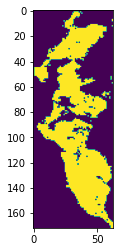

In [11]:
# create a mask based on the environmental variables and fire history
study_region_mask = np.zeros((ndvi.height,ndvi.width))


for i in range(study_region_mask.shape[0]):
    for j in range(study_region_mask.shape[1]):
        found_nan = False
        for var_index in range(covariates_arr.shape[0]):
            if np.isnan(covariates_arr[var_index,i,j]):
                found_nan =True
                break

        for time_step in range(fire_arr.shape[0]):
            if np.isnan(fire_arr[time_step,i,j]):
                found_nan =True
                break
        
        if found_nan:
            study_region_mask[i,j] = -1
        else:
            study_region_mask[i,j] = 1

plt.imshow(study_region_mask)

In [12]:
nan_value = 0

In [13]:
# a mask out function
def mask_layer(input_layer, mask_layer):
    for i in range(mask_layer.shape[0]):
        for j in range(mask_layer.shape[1]):
            if mask_layer[i,j]==-1:
                input_layer[i,j] = nan_value # replace the nan value in the input data

    return input_layer

In [14]:
# created the dataset contains ONLY UNSMOOTHED NDVI DATA
unsmoothed_dataset = ndvi.read()

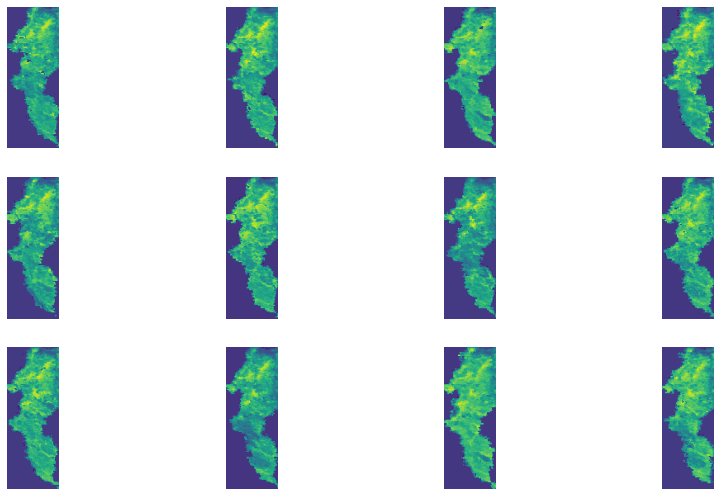

In [15]:
# # visualize random 12 NDVI values of UNSMOOTHED NDVI DATASET
plt.figure(figsize=(15,12))
for i in range(1,13):
    plt.subplot(4,4,i)
    random_time = random.randint(0,ndvi.count-1)
    plt.imshow(unsmoothed_dataset[random_time,:,:])
    plt.axis('off')

In [16]:
# filter the UNSMOOTHED data with the mask

for time_steps in range(0,unsmoothed_dataset.shape[0]):
     unsmoothed_dataset[time_steps,:,:] = mask_layer(unsmoothed_dataset[time_steps,:,:],study_region_mask)


print(np.shape(unsmoothed_dataset))

(748, 172, 63)


convLSTM part

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [18]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
tf.random.set_seed(42)

In [20]:

def create_model():
    tf.random.set_seed(42)

    convLSTM_model = keras.Sequential(
        [
            #keras.Input(shape=(None, 172, 63, 1)),  # Variable-length sequence of 172x63x1 frames
            layers.InputLayer(input_shape=(None, ndvi.height, ndvi.width, 1)),
            layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True),
            #layers.BatchNormalization(),
            layers.Conv3D(filters=1, kernel_size=(3, 3, 3), padding="same",activation="linear"),
        ]
    )
    convLSTM_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())
    return convLSTM_model



In [21]:
# Generate training data
# So we are going to use 75% of the data for training and 25% for testing
# step length is 15


training_size = int(ndvi.count * 0.75) # 561

initial_ndvi = []
next_ndvi = []

for sample_i in range(0,training_size-15):
    #initial_index = random.randint(1,(training_size-16))
    
    this_initial_sequence = []
    this_next_sequence = []
    for t in range(0,15): # each sample has 15 time steps
        #this_initial = ndvi.read(initial_index + t)
        this_initial = unsmoothed_dataset[sample_i + t,:,:]
        this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
        #this_next = ndvi.read(initial_index + t +1)
        this_next = unsmoothed_dataset[sample_i + t + 1,:,:]
        this_next = this_next[..., np.newaxis]
        this_next_sequence.append(this_next)
        
    initial_ndvi.append(this_initial_sequence)
    next_ndvi.append(this_next_sequence)
    

initial_ndvi = np.asarray(initial_ndvi)
next_ndvi = np.asarray(next_ndvi)


In [22]:
initial_ndvi.shape, next_ndvi.shape

((546, 15, 172, 63, 1), (546, 15, 172, 63, 1))

In [23]:
"""
#Train the model
convLSTM_model = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)
epochs = 70  # In practice, you would need hundreds of epochs.

history = convLSTM_model.fit(
    initial_ndvi,
    next_ndvi,
    batch_size=5,
    epochs=epochs,
    verbose=1,
    validation_split=0.1,
    callbacks=[callback]
)

convLSTM_model.save('PretrainedModel/ConvLSTM_unsmoothed_NDVI_only_linear_activation.h5')
"""

'\n#Train the model\nconvLSTM_model = create_model()\ncallback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)\nepochs = 70  # In practice, you would need hundreds of epochs.\n\nhistory = convLSTM_model.fit(\n    initial_ndvi,\n    next_ndvi,\n    batch_size=5,\n    epochs=epochs,\n    verbose=1,\n    validation_split=0.1,\n    callbacks=[callback]\n)\n\nconvLSTM_model.save(\'data-copy/ConvLSTM_unsmoothed_NDVI_only_linear_activation.h5\')\n'

In [24]:
"""
loss_train = history.history["loss"]
loss_val = history.history['val_loss']

plt.plot(loss_train, 'g', label='loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')

plt.legend()
plt.show()
"""

'\nloss_train = history.history["loss"]\nloss_val = history.history[\'val_loss\']\n\nplt.plot(loss_train, \'g\', label=\'loss\')\nplt.plot(loss_val, \'b\', label=\'validation loss\')\nplt.title(\'Training and Validation loss\')\n\nplt.legend()\nplt.show()\n'

In [25]:
convLSTM_model = tf.keras.models.load_model('PretrainedModel/ConvLSTM_unsmoothed_NDVI_only_linear_activation.h5')
convLSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 172, 63, 40) 59200     
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 172, 63, 40) 115360    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 172, 63, 20) 43280     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 172, 63, 10) 10840     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 172, 63, 1)  271       
Total params: 228,951
Trainable params: 228,951
Non-trainable params: 0
_________________________________________________________________


In [26]:
# create test dataset using the remaining 25% data 
test_data_input = []
test_data_label = []


for sample_i in range(training_size, ndvi.count):
    
    test_data_label.append(unsmoothed_dataset[sample_i,:,:])
    this_initial_sequence = []
    for t in range(sample_i-15,sample_i): # each sample has 15 time steps
        this_initial = unsmoothed_dataset[t,:,:]
        this_initial = this_initial[..., np.newaxis]
        this_initial_sequence.append(this_initial)
        
    test_data_input.append(this_initial_sequence)
    
    
test_data_input = np.asarray(test_data_input)
test_data_label = np.asarray(test_data_label)


In [27]:
# Test the model performance based on the generated test data

predicted = convLSTM_model.predict(test_data_input) 
print(np.shape(predicted))

predicted = predicted[::, -1, ::, ::, ::]  
predicted = predicted[:,:,:,0] 
print("the shape of predicted data is " + str(predicted.shape))

(187, 15, 172, 63, 1)
the shape of predicted data is (187, 172, 63)


In [28]:
# find the valid test pixels for RMSE calculation
valid_testlabel = []
valid_predicted = []

for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel.append(test_data_label[i-561,m,n])
                valid_predicted.append(predicted[i-561,m,n])

print(np.shape(valid_testlabel))
print(np.shape(valid_predicted))

(421377,)
(421377,)


In [29]:
# Performance of the ConvLSTM model
from sklearn.metrics import mean_squared_error
rmse =  mean_squared_error(valid_testlabel, valid_predicted, squared=False)
rmse


0.0639028

In [30]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [31]:
import sklearn
from sklearn import metrics
r2 = sklearn.metrics.r2_score(valid_testlabel,valid_predicted)
print(r2)

0.7222114995608802


In [32]:
# find valid input data for baseline1
valid_testlabel1 = []
valid_baseline1 = []


for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel1.append(test_data_label[i-561,m,n])
                valid_baseline1.append(test_data_input[i-561,-1,m,n])


In [33]:
"""
#baseline #1: simply guess as the same of last step
pred_baseline1 = test_data_input[::, -1, ::, ::, 0]
pred_baseline1.shape
"""

'\n#baseline #1: simply guess as the same of last step\npred_baseline1 = test_data_input[::, -1, ::, ::, 0]\npred_baseline1.shape\n'

In [34]:
"""
# performance of the baseline#1
rmse =  mean_squared_error(test_data_label.flatten(), pred_baseline1.flatten(), squared=False)
rmse
"""

'\n# performance of the baseline#1\nrmse =  mean_squared_error(test_data_label.flatten(), pred_baseline1.flatten(), squared=False)\nrmse\n'

In [35]:
# performance of the baseline#1
rmse =  mean_squared_error(valid_testlabel1, valid_baseline1, squared=False)
rmse

0.10372923

In [36]:
r2 = sklearn.metrics.r2_score(valid_testlabel1,valid_baseline1)
print(r2)

0.2680578010459588


In [37]:
# find valid input data for baseline2
valid_testlabel2 = []
valid_baseline2 = []

for m in range(0,172):
    for n in range(0,63):
        for i in range(561,748):
            if qa_arr[i,m,n] == 0 and ndvi_arr[i,m,n]>0 and study_region_mask[m,n] == 1:
                valid_testlabel2.append(test_data_label[i-561,m,n])
                pred_baseline2 = test_data_input[i-561, ::, m, n, 0]
                valid_baseline2.append(np.mean(pred_baseline2,axis = 0))


print(np.shape(valid_testlabel2))
print(np.shape(valid_baseline2))

(421377,)
(421377,)


In [38]:
"""
# baseline #2: average of the past 15 steps
pred_baseline2 = test_data_input[::, ::, ::, ::, 0]
pred_baseline2 = np.mean(pred_baseline2, axis=1)
pred_baseline2.shape
"""

'\n# baseline #2: average of the past 15 steps\npred_baseline2 = test_data_input[::, ::, ::, ::, 0]\npred_baseline2 = np.mean(pred_baseline2, axis=1)\npred_baseline2.shape\n'

In [39]:
# performance of the baseline#2
rmse =  mean_squared_error(valid_testlabel2, valid_baseline2, squared=False)
rmse

0.0709202

In [40]:
r2 = sklearn.metrics.r2_score(valid_testlabel2,valid_baseline2)
print(r2)

0.6578517918941102


In [41]:
pred_baseline1 = test_data_input[::, -1, ::, ::, 0]
pred_baseline2 = test_data_input[::, ::, ::, ::, 0]

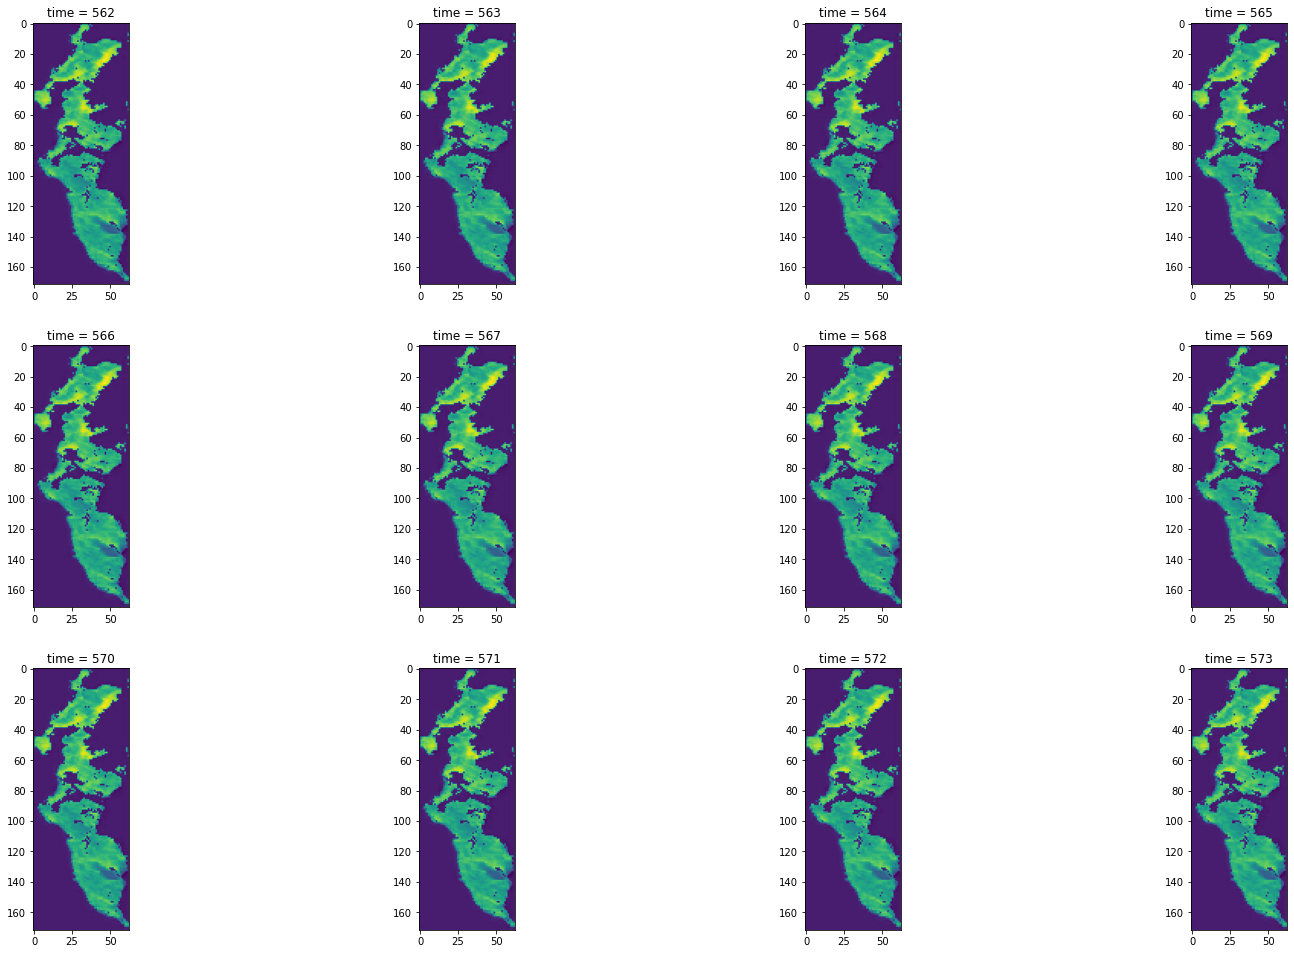

In [42]:
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    plt.subplot(3,4,i)
    #for j in range(1,3):
    predict_series = predicted[j]

    plt.imshow(predict_series)
        #plt.ylim(0.0,1.0)
    plt.title("time = " + str(561+i))


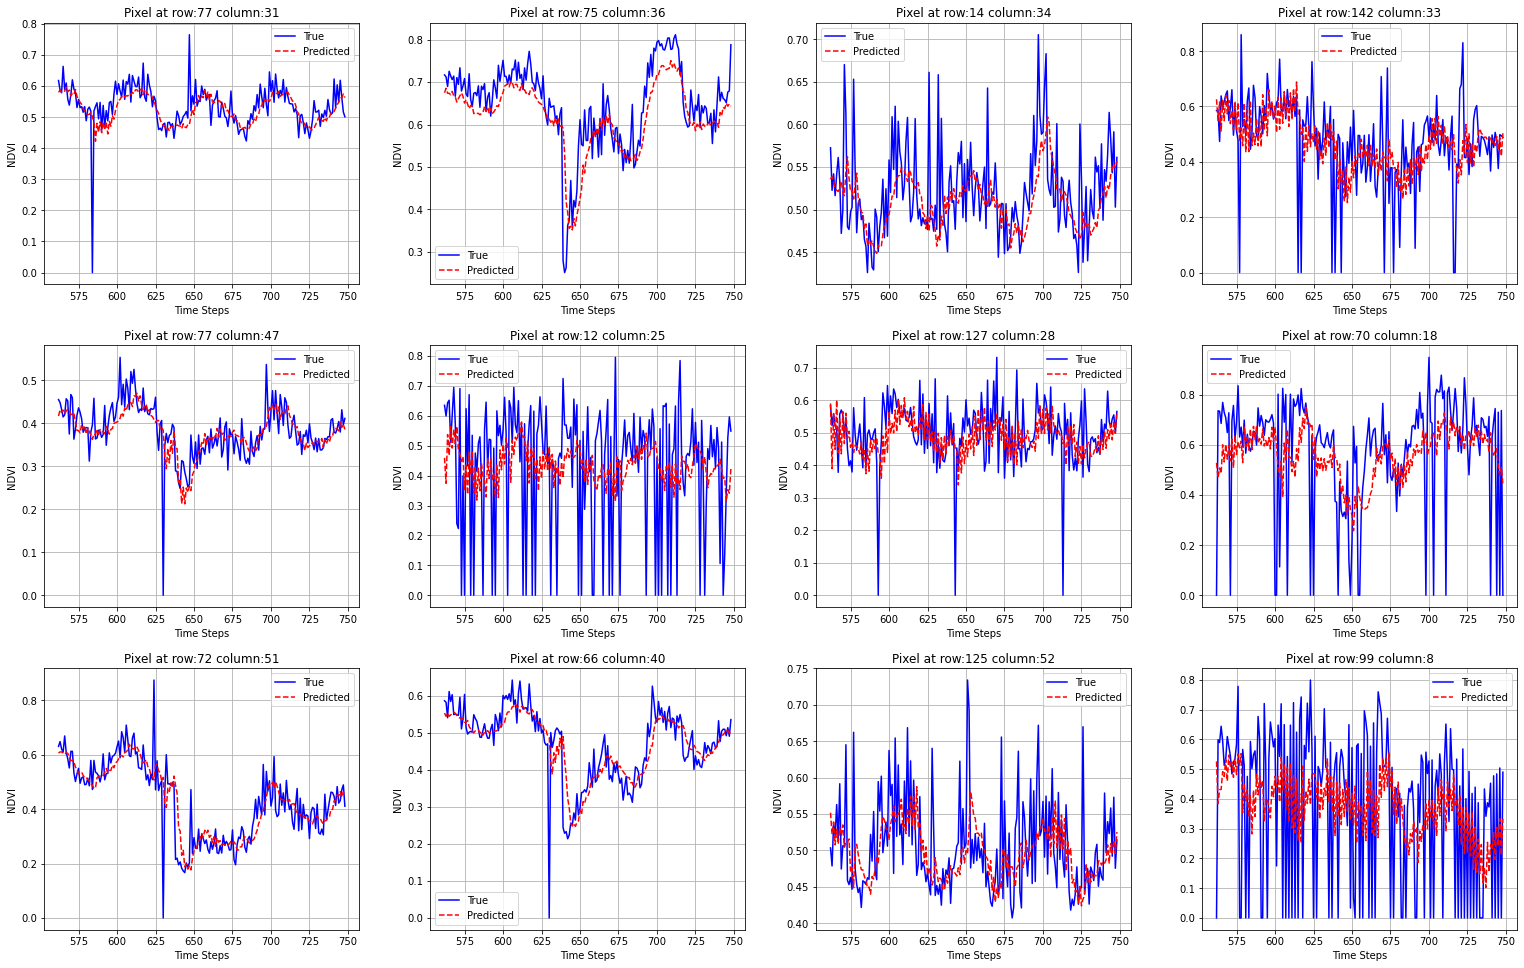

In [43]:
# Visualize the predictions of 12 pixels
time_steps = range(training_size+1, training_size+1+len(test_data_label))

fig, axes = plt.subplots(3,4, figsize=(22,14))
fig.tight_layout(pad=4.0)
for i in range(1,13):
    #for j in range(1,3):

    plt.subplot(3,4,i)

    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)

    true_series = test_data_label[:,pixel_y,pixel_x]
    predict_series = predicted[:,pixel_y,pixel_x]
    plt.plot(time_steps, true_series,"b-", label='True')
    plt.plot(time_steps, predict_series,"r--", label='Predicted')
    #plt.ylim(0.0,1.0)
    plt.xlabel("Time Steps")
    plt.ylabel("NDVI")
    plt.legend()
    plt.grid('on')
    plt.title('Pixel at row:'+str(pixel_y)+" column:"+str(pixel_x))

In [44]:
# calculate temporal rmse of 12 randomly picked pixels
x = []
y = []
for j in range(1,13):
    pixel_y = random.randint(0,ndvi.height-1)
    pixel_x = random.randint(0,ndvi.width-1)

    while study_region_mask[pixel_y,pixel_x] == -1:
        pixel_y = random.randint(0,ndvi.height-1)
        pixel_x = random.randint(0,ndvi.width-1)
    
    x.append(pixel_x)
    y.append(pixel_y)
    
    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,pixel_y,pixel_x] == 0 and ndvi_arr[i,pixel_y,pixel_x] > 0:
            tem_label.append(test_data_label[i-561,pixel_y,pixel_x])
            tem_pred.append(predicted[i-561,pixel_y,pixel_x])

    tem_rmse =  mean_squared_error(tem_label, tem_pred, squared=False)
    print("the temporal RMSE of pixel (" + str(pixel_y) + "," + str(pixel_x) +") " + "is " + str(tem_rmse))

the temporal RMSE of pixel (98,25) is 0.03388438
the temporal RMSE of pixel (18,31) is 0.069259144
the temporal RMSE of pixel (12,50) is 0.041072425
the temporal RMSE of pixel (65,22) is 0.07708484
the temporal RMSE of pixel (101,21) is 0.050331622
the temporal RMSE of pixel (123,25) is 0.13870011
the temporal RMSE of pixel (112,35) is 0.062370908
the temporal RMSE of pixel (159,43) is 0.4230559
the temporal RMSE of pixel (103,40) is 0.11493861
the temporal RMSE of pixel (82,19) is 0.009664714
the temporal RMSE of pixel (115,25) is 0.1058979
the temporal RMSE of pixel (99,9) is 0.0082728565


In [45]:
# calculate temporal r2 of 12 randomly picked pixels
for j in range(1,13):


    tem_label = []
    tem_pred = []
    for i in range(561,748):
        if qa_arr[i,y[j-1],x[j-1]] == 0 and ndvi_arr[i,y[j-1],x[j-1]] > 0:
            tem_label.append(test_data_label[i-561,y[j-1],x[j-1]])
            tem_pred.append(predicted[i-561,y[j-1],x[j-1]])
    tem_r2 = sklearn.metrics.r2_score(tem_label,tem_pred)
    
    print("the temporal R2 of pixel (" + str(y[j-1]) + "," + str(x[j-1]) +") " + "is " + str(tem_r2))

the temporal R2 of pixel (98,25) is 0.42316165100718295
the temporal R2 of pixel (18,31) is -0.4311345955517314
the temporal R2 of pixel (12,50) is 0.5748671824262147
the temporal R2 of pixel (65,22) is 0.7331680082485447
the temporal R2 of pixel (101,21) is -0.14684902065234273
the temporal R2 of pixel (123,25) is -1.3737397707506278
the temporal R2 of pixel (112,35) is 0.45197592924911323
the temporal R2 of pixel (159,43) is nan
the temporal R2 of pixel (103,40) is -3.013444938494408
the temporal R2 of pixel (82,19) is nan
the temporal R2 of pixel (115,25) is -2.9043215290317943
the temporal R2 of pixel (99,9) is nan


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [46]:
# calculate per pixel rmse
spatial_rmse = np.random.rand(ndvi.height,ndvi.width)

for i in range(ndvi.height):
    for j in range(ndvi.width):
        this_true = test_data_label[:,i,j]
        this_predict = predicted[:,i,j]
        this_rmse = mean_squared_error(this_true,this_predict, squared=False)
        spatial_rmse[i,j] = this_rmse

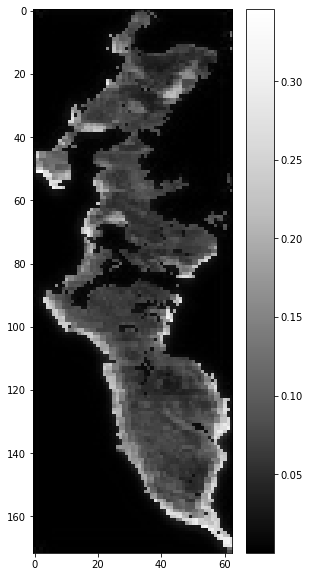

In [47]:
plt.figure(figsize=(5,10))
plt.imshow(spatial_rmse, cmap="Greys_r")
plt.colorbar()